## Convolutional Neural Network for Time Series Prediciton 

#### An application for Italian Energy Prices 

The purpose of this notebook is to demonstrate that convolutional neural networks 
(CNNs) could be applied to time series after they have been transformed into images.
The inspiration for this analysis arose from the desire to apply convolutional neural 
network models, which are typically used for tasks such as image classification and 
image detection, to a regression context. 
This would involve assigning a numerical value 
to each unknown image. 


The work starts with an examination of the driving variables
behind the price of electricity in Italy and aims to show that the transformation of a 
multivariate time series into an image, where each pixel takes on a shade of gray and is 
assigned a label corresponding to a numerical value, such as the PUN value, is effective 
and rich in useful information for predicting the numerical target. From this perspective, 
the analysis yielded excellent results, demonstrating that a time series like electricity 
prices is well-suited to be transformed and processed by a CNN. 

Let's get deep in the work

In [1]:
import nbconvert
import pandoc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
scaler = MinMaxScaler(feature_range = (0, 1))

In [2]:
## LOAD THE DATAFRAME
df = pd.read_excel(r"G:\My Drive\DATASET\Dataset.xlsx")
df = df.set_index('Data')
df = df.dropna()
df = df.iloc[:-408]

#Create lagged values 
df["previous1day_price"] = df["PUN"].shift(24)
df["previous2day_price"] = df["PUN"].shift(24*2)
df["previous3day_price"] = df["PUN"].shift(24*3)
df["previous4day_price"] = df["PUN"].shift(24*4)
df["previous4day_price"] = df["PUN"].shift(24*5)

## Apply a smoothing tecnique to Wind, it has a spiky shape
df['Smoothed_Wind'] = df['Wind'].rolling(window=24).mean()

# I created a week SMA in order to get the trends 
df['SMA_PUN'] = df['PUN'].rolling(window=24*7).mean()

# I create temporal variables with a simple function

def create_features(df):
    df = df.copy()
    df["hour"] = df.index.hour+1
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    #df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    return df
    
df = create_features(df)

df = df.tail(24*30*2)

dfwithpun = df.round(2)

## Feature Selection

Get the most important 24 variables to ensure scalability with two different methods:

#### PCA

#### DECISION TREE
This two approaches of feature selection are often suggested in the state of the Art, for 
example PCA has the potential to perform feature selection and is able to select a 
number of important individuals from all the feature components . On the other hand 23
Classification and Regression Trees (CART), introduced by Breiman et al., is a statistical 
technique that can select from a large number of explanatory variables (x) those that are 
most important in determining the response variable (y) to be explained. This is done by 
growing a tree structure, which partitions the data into mutually exclusive groups (nodes) 
each as pure or homogeneous as possible concerning their response variable.

##### PCA

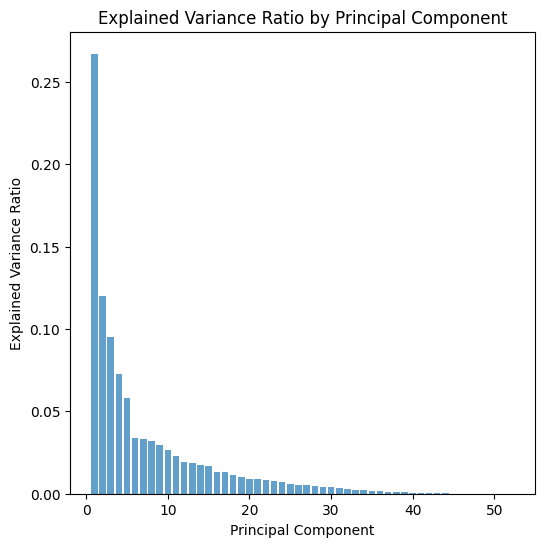

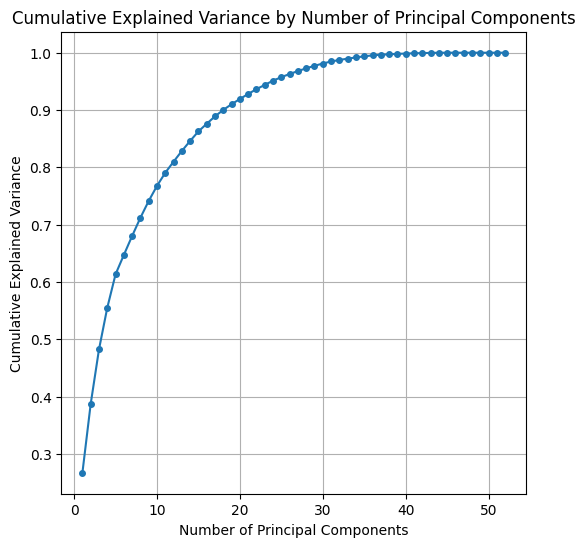

Top 24 Most Important Variables:
Centre_South
Italy
Sicily
South
Sardinia
Centre-North
Calabria
North
BA temp
Autoconsumption
MI temp
BA rhum
dayofyear
Geothermal 
MI rhum
Photovoltaic
SMA_PUN
Thermal
month
hour
MI dwpt
quarter
BA wdir
BA dwpt


In [3]:
from sklearn.decomposition import PCA

data = df.drop(columns=['PUN'])

scaler = StandardScaler()
data_standardized = scaler.fit_transform(data)

# Apply PCA
pca = PCA()
pca.fit(data_standardized)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Number of principal components
n_components = len(explained_variance_ratio)

# Plot explained variance ratio
plt.figure(figsize=(6, 6))
plt.bar(range(1, n_components + 1), explained_variance_ratio, alpha=0.7, align='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()

# Plot cumulative explained variance
plt.figure(figsize=(6, 6))
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='-', markersize=4)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()

# Sort variables by their importance (loadings) in the first principal component
first_principal_component_loadings = pca.components_[0]
sorted_indices = np.argsort(np.abs(first_principal_component_loadings))[::-1]

# Get the names of the 24 most important variables
top_24_variable_names = data.columns[sorted_indices[:24]]
print("Top 24 Most Important Variables:")
for variable_name in top_24_variable_names:
    print(variable_name)

##### DECISION TREE

In [4]:
from sklearn.tree import DecisionTreeRegressor, plot_tree


data = df
X = data.drop(columns=['PUN'])  # Features (exclude 'PUN')
y = data['PUN']  # Target variable

# Train a decision tree regression model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X, y)

# Get feature importances
feature_importances = tree_model.feature_importances_

# Sort variables by importance in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Get the names of the top 24 most important variables
top_24_variable_names = X.columns[sorted_indices[:24]]
print("Top 24 Most Important Variables Related to PUN: \n" )
for variable_name in top_24_variable_names:
    print(variable_name)
    
    
filtered_df = df[top_24_variable_names]


#Scale the Dataframe
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(filtered_df)
scaled_df = pd.DataFrame(scaled_df, columns=filtered_df.columns, index=filtered_df.index)
df = scaled_df

Top 24 Most Important Variables Related to PUN: 

previous1day_price
Thermal
Smoothed_Wind
Hydro
MI dwpt
dayofyear
SMA_PUN
BA pres
previous4day_price
Centre-North
Net Physical Exchange France 
Net Physical Exchange Switzerland 
Photovoltaic
previous2day_price
BA dwpt
hour
Flows
Centre_South
MI temp
Wind
BA wdir
Sardinia
Net Scheduled Exchange France 
Calabria


## Encoding

#### Raw Pixel Images
Assign to each pixel of the image a color of the scale "Plasma" palette, dipending on the scale value of the feature in that timestamp. 
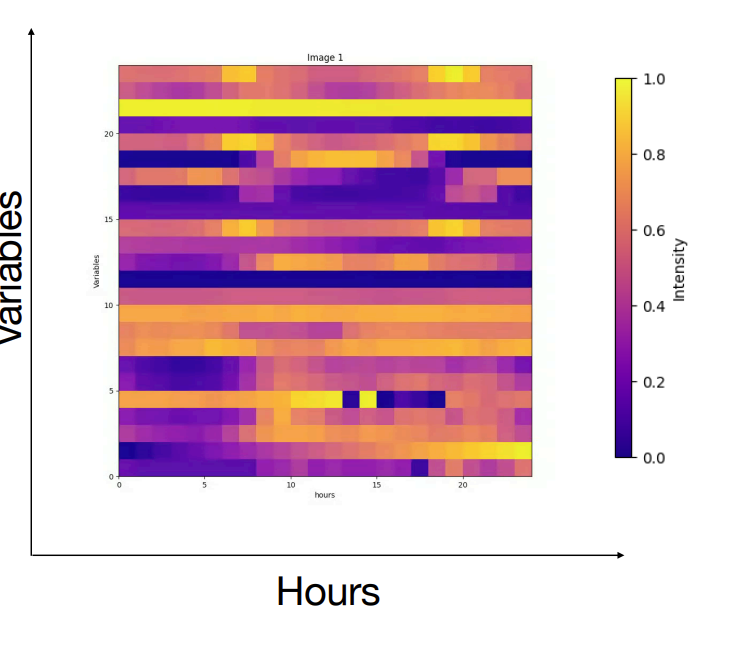

## Labeling
Give a label to each image so that 
the model can learn and then predict 
on unseen data. 


The method: Associate each image 
with the corresponding PUN value at 
the twenty-fourth hour, which is the 
value associated with the last array 
of pixels. 

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import io
from numpy import asarray

window_size = 24

figsize = 1

images = []
labels = []
images_array=[]

# Iterate over the DataFrame to create images and labels
for i in range(len(df) - window_size + 1):
    
    # Extract data for the current window
    window_data = df.iloc[i:i + window_size]
    window_dataPUN = dfwithpun.iloc[i:i + window_size]

    # Create a simple plot
    plt.figure(figsize=(figsize, figsize))
    plt.imshow(window_data.T, cmap='plasma', aspect='auto', extent=[0, window_data.shape[1], 0, window_data.shape[0]])
    plt.axis('off')

    
    # Save the plot as a PNG image
    image_buffer = io.BytesIO()
    plt.savefig(image_buffer, format='png')
    image_buffer.seek(0)
    # Open the saved PNG image using PIL
    image = Image.open(image_buffer)
    image_array = asarray(image)
    images_array.append(image_array)
    # Add the PIL image to the list
    images.append(image)
    #plt.show()

    # Close the plot
    plt.close()

    # Extract the label (last "PUN" value in the window)
    label = window_dataPUN.iloc[-1]['PUN']
    #plt.show()
    #print("PUN: ",label)
    labels.append(label)

# Convert the lists to NumPy arrays for further processing

images_array = [np.array(img) for img in images_array]
# Normalize the pixel values between 0 and 1
images_array = np.array(images_array) / 255.0

labels = np.array(labels)

PNG
(100, 100)
RGBA
<class 'numpy.ndarray'>
(100, 100, 4)


array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       ...,

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1.

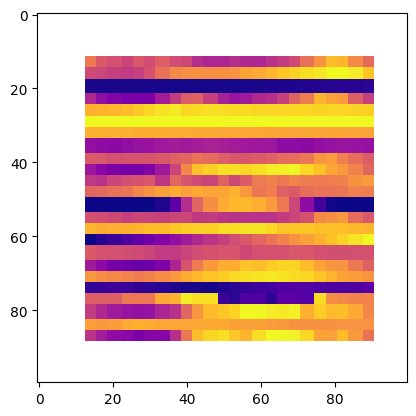

In [6]:
# summarize some details about the image
plt.imshow(image)
print(images[0].format)
print(images[0].size)
print(images[0].mode)


print(type(images_array[0]))
print(images_array[0].shape)
images_array[1]

### Ooops, I need to remove border from my images!!
Let's create a function to do it

PNG
(100, 100)
RGBA
<class 'numpy.ndarray'>
(77, 78, 4)
77
78
4


array([[[0.80784314, 0.29019608, 0.45882353, 1.        ],
        [0.80784314, 0.29019608, 0.45882353, 1.        ],
        [0.80784314, 0.29019608, 0.45882353, 1.        ],
        ...,
        [0.8627451 , 0.36470588, 0.4       , 1.        ],
        [0.8627451 , 0.36470588, 0.4       , 1.        ],
        [0.8627451 , 0.36470588, 0.4       , 1.        ]],

       [[0.80784314, 0.29019608, 0.45882353, 1.        ],
        [0.80784314, 0.29019608, 0.45882353, 1.        ],
        [0.80784314, 0.29019608, 0.45882353, 1.        ],
        ...,
        [0.8627451 , 0.36470588, 0.4       , 1.        ],
        [0.8627451 , 0.36470588, 0.4       , 1.        ],
        [0.8627451 , 0.36470588, 0.4       , 1.        ]],

       [[0.80784314, 0.29019608, 0.45882353, 1.        ],
        [0.80784314, 0.29019608, 0.45882353, 1.        ],
        [0.80784314, 0.29019608, 0.45882353, 1.        ],
        ...,
        [0.8627451 , 0.36470588, 0.4       , 1.        ],
        [0.8627451 , 0.364705

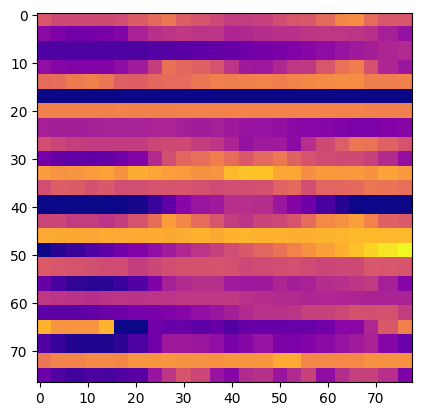

In [7]:
def remove_white_background(image):
    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Find the coordinates of non-white pixels
    non_white_coords = np.argwhere(image_array < 1)

    # Get the minimum and maximum coordinates of non-white pixels
    min_coords = non_white_coords.min(axis=0)
    max_coords = non_white_coords.max(axis=0)

    # Crop the image to the bounding box of non-white pixels
    cropped_image = image_array[min_coords[0]:max_coords[0]+1, min_coords[1]:max_coords[1]+1, :]

    return cropped_image

# Apply the remove_white_background function to each image in the tensor
images_array = [remove_white_background(image) for image in images_array]

# Convert the list of cropped images back to a NumPy array
images_array = np.array(images_array)

# summarize some details about the image
plt.imshow(images_array[0])
print(images[0].format)
print(images[0].size)
print(images[0].mode)

print(type(images_array[0]))
print(images_array[0].shape)
print(images_array[0].shape[0])
print(images_array[0].shape[1])
print(images_array[0].shape[2])
images_array[1]

### Much better! 

## The CNN Model

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/100
36/36 [==============================] - 5s 112ms/step - loss: 0.0694 - val_loss: 0.0235
Epoch 2/100
36/36 [==============================] - 4s 100ms/step - loss: 0.0274 - val_loss: 0.0195
Epoch 3/100
36/36 [==============================] - 4s 103ms/step - loss: 0.0237 - val_loss: 0.0192
Epoch 4/100
36/36 [==============================] - 4s 103ms/step - loss: 0.0245 - val_loss: 0.0214
Epoch 5/100
36/36 [==============================] - 4s 103ms/step - loss: 0.0266 - val_loss: 0.0297
Epoch 6/100
36/36 [==============================] - 4s 101ms/step - loss: 0.0271 - val_loss: 0.0212
Epoch 7/100
36/36 [==============================] - 4s 102ms/step - loss: 0.0211 - val_loss: 0.0149
Epoch 8/100
36/36 [==============================] - 4s 100ms/step - loss: 0.0183 - val_loss: 0.0133
Epoch 9/100
36/36 [========================

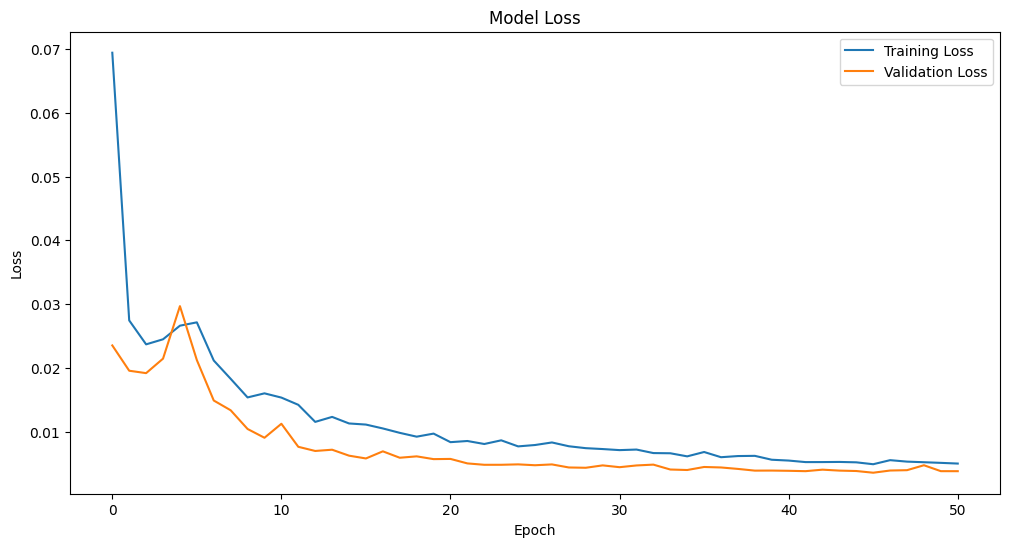

In [8]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping


# Step 1: Prepare the dataset
X_train, X_test, y_train, y_test = train_test_split(images_array, labels, test_size=0.2, random_state=42)

# Normalize images
X_train = X_train / 255.0
X_test = X_test / 255.0

# Scale labels from 0 to 1
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()

# Step 2: Build and train the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(images_array[0].shape[0],images_array[0].shape[1], images_array[0].shape[2])),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5), ## Questo layer dovrebbe prevenire dall'overfitting! (Insieme all'early stopping)
    tf.keras.layers.Dense(1)  # Output layer with one neuron for regression
])

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

model.compile(optimizer='adam', loss='mean_squared_error')

# INTRODUCO UN EARLY STOPPING
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])

plot_model(model, to_file='model_architecture.png', show_shapes=True)


# Evaluate the model using MAPE
y_pred = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

# Step 4: Save the training history and plot the main metrics
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

9/9 [==============================] - 0s 18ms/step


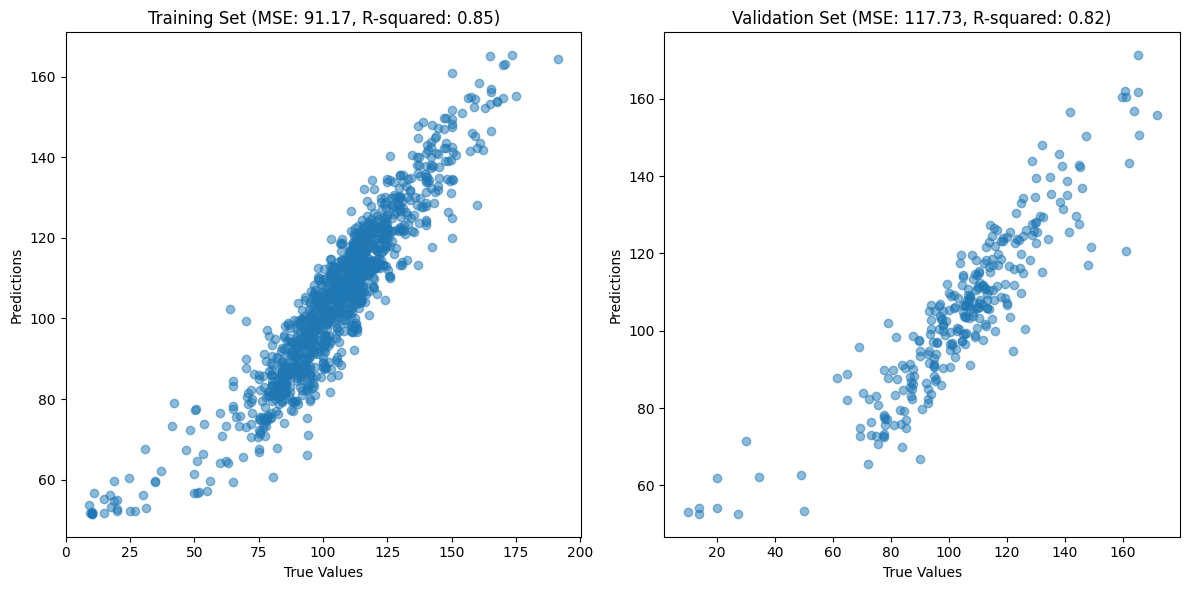

In [9]:
from sklearn.metrics import mean_squared_error, r2_score

# Train and validation predictions
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_test)

# Inverse transform target variable predictions
train_predictions = scaler.inverse_transform(train_predictions)
val_predictions = scaler.inverse_transform(val_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


# Calculate the mean squared error for train and validation sets
train_mse = mean_squared_error(y_train, train_predictions)
val_mse = mean_squared_error(y_test, val_predictions)

# Calculate the R-squared (coefficient of determination) for train and validation sets
train_r2 = r2_score(y_train, train_predictions)
val_r2 = r2_score(y_test, val_predictions)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot training data
plt.subplot(1, 2, 1)
plt.scatter(y_train, train_predictions, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title(f"Training Set (MSE: {train_mse:.2f}, R-squared: {train_r2:.2f})")

# Plot validation data
plt.subplot(1, 2, 2)
plt.scatter(y_test, val_predictions, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title(f"Validation Set (MSE: {val_mse:.2f}, R-squared: {val_r2:.2f})")

plt.tight_layout()
plt.show()

In [10]:
# Step 5: Predict the last 24 values of labels with the last 24 images available
giorni = 7

last_24_images = images_array[-24*giorni:]/ 255.0
last_24_predictions = model.predict(last_24_images)
last_24_predictions = scaler.inverse_transform(last_24_predictions)

print("Predictions for the last 24 hours:")
print(last_24_predictions)
print(labels[-24*giorni:])

6/6 [==============================] - 0s 14ms/step
Predictions for the last 24 hours:
[[118.38975 ]
 [110.371216]
 [105.13875 ]
 [102.13419 ]
 [100.748146]
 [104.217125]
 [112.59154 ]
 [119.8341  ]
 [123.03633 ]
 [120.732445]
 [118.874344]
 [117.472565]
 [116.710075]
 [117.92355 ]
 [121.04187 ]
 [123.30253 ]
 [124.023285]
 [128.00882 ]
 [137.91809 ]
 [153.94254 ]
 [162.9544  ]
 [154.77843 ]
 [139.64464 ]
 [125.98419 ]
 [116.96699 ]
 [111.338196]
 [107.56913 ]
 [105.49693 ]
 [106.08084 ]
 [110.78878 ]
 [117.74606 ]
 [123.31772 ]
 [126.31824 ]
 [124.87022 ]
 [122.29186 ]
 [119.212776]
 [116.42285 ]
 [115.3767  ]
 [116.76626 ]
 [119.86813 ]
 [120.83206 ]
 [122.47512 ]
 [130.47672 ]
 [142.28029 ]
 [148.20955 ]
 [140.55676 ]
 [128.51102 ]
 [116.623405]
 [108.747955]
 [100.63685 ]
 [ 95.19305 ]
 [ 94.668076]
 [ 95.15014 ]
 [ 98.99797 ]
 [105.59974 ]
 [111.23434 ]
 [113.98635 ]
 [110.908485]
 [106.97517 ]
 [103.86007 ]
 [102.16312 ]
 [102.08881 ]
 [103.19077 ]
 [104.96767 ]
 [104.24193 ]
 [1

Mean Squared Error (MSE): 39.31
R-squared (R2): 0.89
Mean Absolute Percentage Error (MAPE): 4.52%


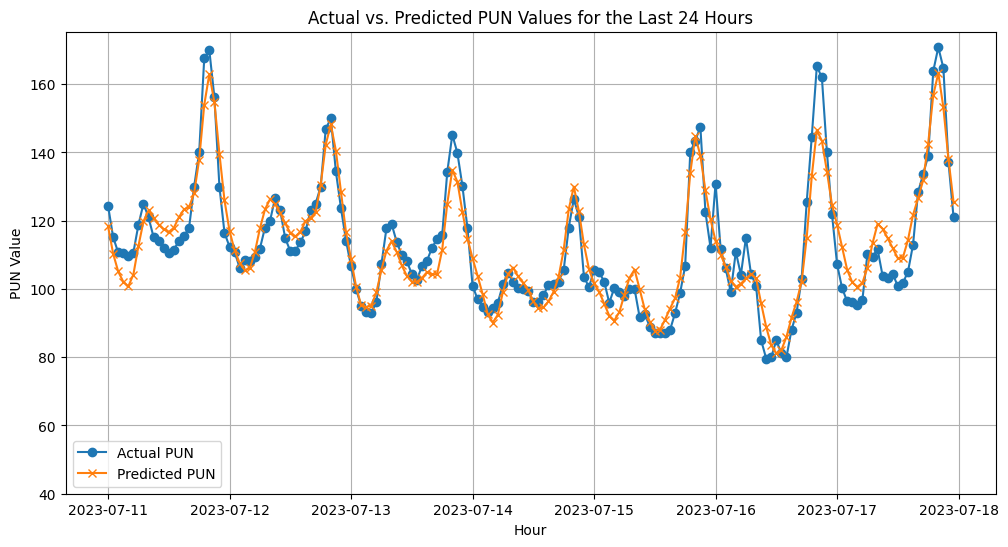

In [11]:
mse = mean_squared_error(labels[-24*giorni:], last_24_predictions)
r2 = r2_score(labels[-24*giorni:], last_24_predictions)
mape = mean_absolute_percentage_error(labels[-24*giorni:], last_24_predictions)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

# Plot the predictions vs. actual labels
plt.figure(figsize=(12, 6))
plt.plot(df.index[-24*giorni:], labels[-24*giorni:], label='Actual PUN', marker='o')
plt.plot(df.index[-24*giorni:], last_24_predictions, label='Predicted PUN', marker='x')
plt.xlabel('Hour')
plt.ylabel('PUN Value')
plt.title('Actual vs. Predicted PUN Values for the Last 24 Hours')
plt.ylim(40, plt.ylim()[1])
plt.legend()
plt.grid()
plt.show()

## MAPE BY HOUR

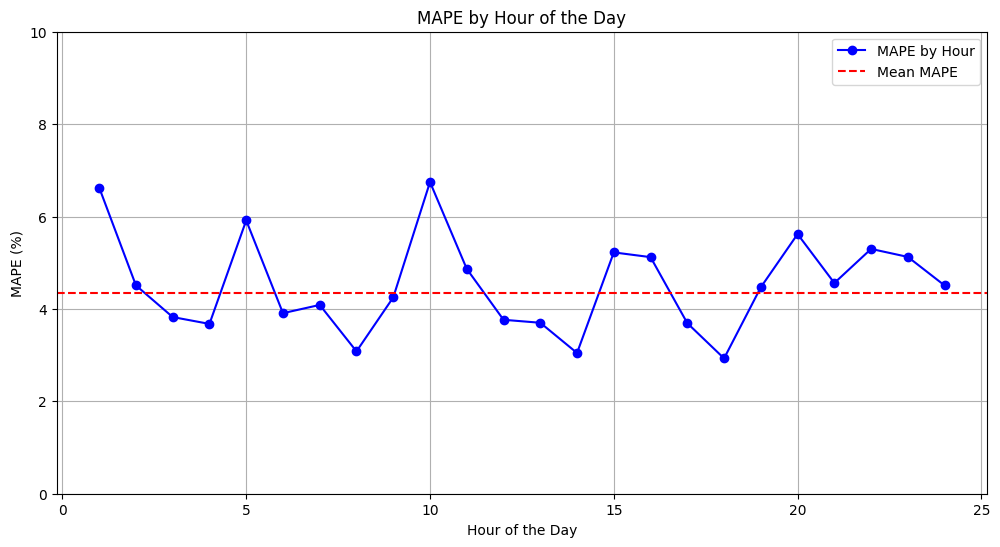

In [12]:
last_24_predictions = pd.DataFrame(last_24_predictions)
last_24_predictions.index = df.index[-24*giorni:]
labels = labels[-24*giorni:]
labels = pd.DataFrame(labels)
labels.index = df.index[-24*giorni:]

# Assuming last_24_predictions and labels have the same shape
mape_by_hour = []

for hour in range(24):
    predictions_hour = last_24_predictions[hour::24]  # Select every 24th column (hourly data)
    labels_hour = labels[hour::24]  # Select every 24th column (hourly data)
    
    absolute_percentage_errors = np.abs((predictions_hour - labels_hour) / labels_hour)
    mape_hour = absolute_percentage_errors.mean() * 100
    mape_by_hour.append(mape_hour[0])
# Create a DataFrame to store MAPE values by hour
mape_df = pd.DataFrame({'Hour': range(1,25), 'MAPE': mape_by_hour})
mape_df = mape_df.set_index('Hour')    
    
# Plot the MAPE values
plt.figure(figsize=(12, 6))
plt.plot(mape_df.index, mape_df['MAPE'], marker='o', linestyle='-', color='b', label='MAPE by Hour')

# Calculate the mean MAPE
mean_mape = mape_df['MAPE'].mean()

# Plot the mean as a straight line
plt.axhline(4.34, color='r', linestyle='--', label='Mean MAPE')

# Add labels and legend
plt.xlabel('Hour of the Day')
plt.ylabel('MAPE (%)')
plt.title('MAPE by Hour of the Day')
plt.ylim(0,10)
plt.legend()

# Show the plot
plt.grid(True)
plt.show()    

• The lack of jumps in MAPE by hour demonstrates the model reliability 


• The demonstration that images can effectively explain a numerical label in a regression context lays 
the foundation for applying the model to make day-ahead forecasts 


• A forecast on a prediction need good accuracy